In [2]:
from gensim import corpora
from gensim import models
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import log_loss, accuracy_score
from scipy.sparse import csr_matrix
import numpy as np
import os
import re
from tqdm import tqdm 
import pickle

## Read Data

In [3]:
with open('new_data_correct.p', 'rb') as fp:
    data = pickle.load(fp)

In [4]:
for i in data:
    if(data[i]['depression']==10):
        print(i)
print(data['N18166S'])

N14580L
{'essay': u'name name years old married little boy life leading good interests gardening jigsaw making make jigsaw nothing home life interesting sit watch monday watch blue letter work builder build story flat factor school jobs lot others need scaffolding stand get top building go scaffolding get bricks cement sore legs going scaffolding time got good exercise go home fit fiddle dinner come back dinner scaffolding building exercise go weeks wages pocket got week little boy name staying next door labour work train set works battery cost garden quite nice prize dining telling deep green house favoured program comes witch go watch shown left brick one hand last week garden wonted ground soft potatoes cover frost dose get plant onions shots words ', 'wrong': 32, 'anxiety': 1.0, 'depression': 1.0}


In [5]:
raw_corpus = np.array([data[i]['essay'] for i in data])
y_label = np.array([int(data[i]['depression']) for i in data])
y_label[y_label>0] = 1
print(sum(np.array(y_label)==0))
print(sum(np.array(y_label)==1))

5406
4049


In [694]:
# Create a set of frequent words
# Lowercase each document, split it by white space
texts = [[word for word in document.lower().split()]
         for document in raw_corpus]

# Count word frequencies
from collections import defaultdict
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1


# Only keep words that appear more than once
processed_corpus = []
for i in tqdm(range(len(texts))):
    processed_corpus.append([token for token in texts[i] if frequency[token] > 1])

100%|██████████| 9455/9455 [00:00<00:00, 9502.00it/s] 


## Prepocess Data

### (1) Use gensim to get bag-of-words

Before proceeding, we want to associate each word in the corpus with a unique integer ID. We can do this using the gensim.corpora.Dictionary class. This dictionary defines the vocabulary of all words that our processing knows about.

In [695]:
dictionary = corpora.Dictionary(processed_corpus)
print(len(dictionary))

11059


To infer the latent structure in our corpus we need a way to represent documents that we can manipulate mathematically. One approach is to represent each document as a vector. There are various approaches for creating a vector representation of a document but a simple example is the bag-of-words model. Under the bag-of-words model each document is represented by a vector containing the frequency counts of each word in the dictionary. For example, given a dictionary containing the words ['coffee', 'milk', 'sugar', 'spoon'] a document consisting of the string "coffee milk coffee" could be represented by the vector [2, 1, 0, 0] where the entries of the vector are (in order) the occurrences of "coffee", "milk", "sugar" and "spoon" in the document. The length of the vector is the number of entries in the dictionary. One of the main properties of the bag-of-words model is that it completely ignores the order of the tokens in the document that is encoded, which is where the name bag-of-words comes from.

In [696]:
bow_corpus = [dictionary.doc2bow(text) for text in processed_corpus]
print(len(bow_corpus))

9455


In [801]:
print(raw_corpus[0])
print(bow_corpus[0])

going lead good house children going spot ever done long shall punished give money school every day daily bad wont give pen week going tutors alone words 
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 3), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1)]


### (2) tf-idf

Initialize the tf-idf model, training it on our corpus and transforming the all strings:

In [697]:
# train the model
tfidf = models.TfidfModel(bow_corpus)
# transform the all strings
corpus_tfidf = tfidf[bow_corpus]
print(len(corpus_tfidf))

9455


## Machine Learning

We use the dataset to train the KNN model:

In [770]:
#transfer the data set from tuple list to matrix representation 
Tdata = []
rows = []
cols = []
line_count = 0
for line in corpus_tfidf:
    for elem in line:
        rows.append(line_count)
        cols.append(elem[0])
        Tdata.append(elem[1])
    line_count += 1
lsi_matrix = csr_matrix((Tdata,(rows,cols))).toarray()

In [781]:
# separate train set and test set
rarray=np.random.random(size=line_count)
train_set = []
train_tag = []
test_set = []
test_tag = []
rarray_2=np.random.random(size=line_count)
for i in range(line_count):
    if rarray[i]<0.8:
        train_set.append(lsi_matrix[i,:])
        train_tag.append(y_label[i])
    else:
        test_set.append(lsi_matrix[i,:])
        test_tag.append(y_label[i])

In [782]:
print(sum(np.array(train_tag)==0))
print(sum(np.array(train_tag)==1))

4322
3226


In [783]:
# tests the accuracy of a classifier
def test(testData, testLabels, classifier):
    correct=0.
    prediction = classifier(testData)
    correct += np.sum(prediction==testLabels)

    return correct/len(testData)*100

In [784]:
class KNNClassifer():
    def __init__(self, k=101):
        self.classifier = KNeighborsClassifier(n_neighbors = k, algorithm = 'brute')
        
    def train(self, trainData, trainLabels):
        self.classifier.fit(trainData, trainLabels)
        
        
    def __call__(self, x):
        return self.classifier.predict(x)
    

knnClassiferX = KNNClassifer()
knnClassiferX.train(train_set, train_tag)



In [785]:
print ('KNN classifier accuracy: %f'%test(test_set, test_tag, knnClassiferX))

KNN classifier accuracy: 61.405349


## Analysis

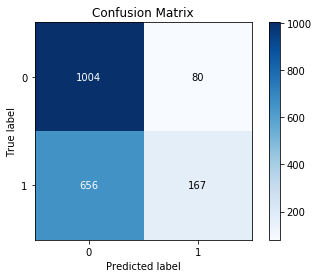

In [786]:
# plot confusion matrix
prediction = knnClassiferX(test_set)
skplt.metrics.plot_confusion_matrix(test_tag, prediction)
plt.show()

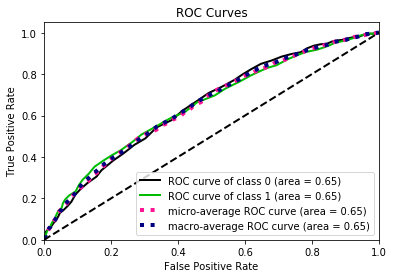

In [793]:
# plot ROC
nb = KNeighborsClassifier(n_neighbors = 201, algorithm = 'brute')
nb = nb.fit(train_set, train_tag)
y_probas = nb.predict_proba(test_set)
skplt.metrics.plot_roc(test_tag, y_probas)
plt.show()

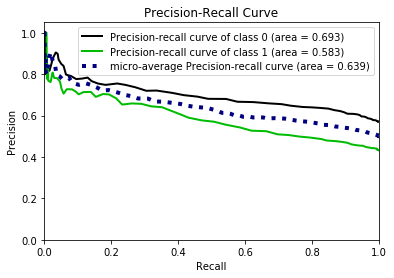

In [797]:
# plot PRC
skplt.metrics.plot_precision_recall(test_tag, y_probas)
plt.show()